In [8]:
import pandas as pd
import numpy as np

# Talent Migration in South Asia

The data and methodology used in this notebook are a product [World Bank research in collaboration with LinkedIn](https://documents1.worldbank.org/curated/en/827991542143093021/pdf/World-Bank-Group-LinkedIn-Data-Insights-Jobs-Skills-and-Migration-Trends-Methodology-and-Validation-Results.pdf)

In [495]:
country_migration = pd.read_csv('../../data/LinkedIn/country_migration_official_use.csv')
industry_migration = pd.read_csv('../../data/LinkedIn/industry_migration_official_use.csv')
skills_migration = pd.read_csv('../../data/LinkedIn/skill_migration_official_use.csv')
#linkedin_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name=')

In [45]:
country_flows = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name='1. country_inflow_outflow')
country_industry_flow = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name='2. country_inflow_outflow_ind')
country_skill_flow = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name='3. country_inflow_outflow_skill')

pairwise_skill_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name = '6. pairwise_flows_skill')
pairwise_industry_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name = '5. pairwise_flows_ind')
pairwise_country_migration = pd.read_excel('../../data/LinkedIn/Public Use_LinkedIn Migration Data.xlsx', sheet_name = '4. pairwise_flows')

In [485]:
countries_of_interest = ['India', 'Bangladesh', 'Sri Lanka', 'Maldives']
benchmark_countries = ['United States', 'Turkey', 'South Africa', 'Indonesia']

## Country Industry Size Location Quotient


LQ = (Country Industry Size) / (Income Group Average Industry Size)

### Methodology
**Step 1**: Calculate Country Industry Size

Country Industry Size = (Employment in Industry i in Country c) / (Total Employment in Country c)

**Step 2**: Calculate Income Group Average Industry Size

Income Group Average = Σ(Country Industry Size for all countries in income group) / Number of countries in income group

**Step 3**: Calculate Location Quotient
LQ = (Country Industry Size) / (Income Group Average Industry Size)

For country c, industry i, and income group I:
LQ(c,i) = [e(c,i) / e(c,total)] / [Σ(e(k,i) / e(k,total)) / n]
Where:

e(c,i) = Employment in industry i in country c
e(c,total) = Total employment in country c
k = Each country in the same income group as country c
n = Number of countries in the income group
Σ = Sum across all countries in the income group

Alternative Compact Form
LQ(c,i) = (e(c,i) / e(c,total)) / (1/n × Σ[e(k,i) / e(k,total)])
Interpretation

- LQ > 1: Country has higher concentration in this industry compared to income group peers
- LQ = 1: Country matches the income group average
- LQ < 1: Country has lower concentration compared to income group peers

**Notes**

- Unweighted Average: Each country in the income group is treated as one observation regardless of country size
- Income Group Benchmark: Countries are compared against peers at similar development levels, not global averages
- Relative Measure: LQ shows relative specialization, not absolute employment levels

In [231]:
def calculate_location_quotient(df: pd.DataFrame, level: str = 'industry') :
    """
    Calculates the Location Quotient (LQ) for each country and industry/section across multiple years
    using World Bank methodology (income group benchmark).

    The Location Quotient formula is:
    LQ = (Country industry size) / (Income group average industry size)
    
    Where:
    - Country industry size = (employment in industry i in country c) / (total employment in country c)
    - Income group average = arithmetic mean of industry sizes across all countries in the same income group
      (each country treated as one observation regardless of size)

    Args:
        df (pd.DataFrame): DataFrame with columns for country, industry, wb_income and
                           yearly employment counts (e.g., 'total_member_cnt_YYYY').
        level (str): Level of aggregation - either 'industry' or 'section'.
                     Defaults to 'industry'.

    Returns:
        pd.DataFrame: A DataFrame with the original identifiers plus the
                      year, employment count, and calculated LQ for each row.
    """
    if level not in ['industry', 'section']:
        raise ValueError("Level must be either 'industry' or 'section'")
    
    # 1. Reshape data from wide to long format
    id_cols = [
        'country_code', 'country_name', 'wb_income', 'wb_region',
        'isic_section_index', 'isic_section_name', 'industry_id', 'industry_name'
    ]
    value_cols = [col for col in df.columns if 'total_member_cnt_' in col]
    
    if not value_cols:
        raise ValueError("No 'total_member_cnt_YYYY' columns found in the DataFrame.")

    long_df = pd.melt(
        df,
        id_vars=id_cols,
        value_vars=value_cols,
        var_name='year',
        value_name='employment'
    )

    # Clean up the 'year' column to be an integer
    long_df['year'] = long_df['year'].str.extract(r'(\d{4})').astype(int)

    # For robustness, fill any potential NaN employment values with 0
    long_df['employment'] = long_df['employment'].fillna(0)

    # 2. Aggregate data based on chosen level
    if level == 'section':
        # Aggregate employment at ISIC section level
        aggregation_cols = ['country_code', 'country_name', 'wb_income', 'wb_region',
                           'isic_section_index', 'isic_section_name', 'year']
        
        long_df = long_df.groupby(aggregation_cols)['employment'].sum().reset_index()
        
        # Set the grouping variables for LQ calculation
        industry_group_col = 'isic_section_index'
        output_id_cols = aggregation_cols
        
    else:  # level == 'industry'
        # Keep original industry-level data
        aggregation_cols = ['country_code', 'country_name', 'wb_income', 'wb_region',
                           'isic_section_index', 'isic_section_name','industry_name', 'industry_id', 'year']
        
        long_df = long_df.groupby(aggregation_cols)['employment'].sum().reset_index()

        industry_group_col = 'industry_id'
        output_id_cols = aggregation_cols

    # 3. Calculate country industry size (Step 1 from WB methodology)
    # Country industry size = employment in industry i / total employment in country
    long_df['country_total_employment'] = long_df.groupby(['country_code', 'year'])['employment'].transform('sum')
    long_df['country_industry_size'] = long_df['employment'] / long_df['country_total_employment']
    
    # Handle division by zero (countries with no employment)
    long_df['country_industry_size'] = long_df['country_industry_size'].fillna(0)

    # 4. Calculate income group average industry size (Step 2 from WB methodology)
    # Arithmetic mean of industry sizes across countries in same income group
    # Each country treated as one observation regardless of country size
    long_df['income_group_avg_industry_size'] = long_df.groupby(['wb_income', industry_group_col, 'year'])['country_industry_size'].transform('mean')

    # 5. Calculate Location Quotient
    # LQ = Country industry size / Income group average industry size
    long_df['lq'] = long_df['country_industry_size'] / long_df['income_group_avg_industry_size']
    
    # Handle division by zero and infinite values
    long_df['lq'] = long_df['lq'].replace([np.inf, -np.inf], 0).fillna(0)
    
    # Select and reorder columns for a clean output
    final_output_cols = output_id_cols + ['employment', 'country_industry_size', 'income_group_avg_industry_size', 'lq']
    
    return long_df[final_output_cols]

In [232]:
industry_count = industry_migration[['country_code', 'country_name', 'wb_income', 'wb_region',
       'isic_section_index', 'isic_section_name', 'industry_id',
       'industry_name', 'total_member_cnt_2015', 'total_member_cnt_2016','total_member_cnt_2017',
       'total_member_cnt_2018', 'total_member_cnt_2019']].drop_duplicates()

industry_count = industry_count[industry_count['country_name'].isin(countries_of_interest + benchmark_countries)]

In [233]:
lq_section = calculate_location_quotient(industry_count, level='section')
lq_industry = calculate_location_quotient(industry_count, level='industry')

In [110]:
industry_mapping = pd.read_csv('../../data/LinkedIn/linkedin_to_isic_rev_4_industry_mapping_0.csv')

In [267]:
import numpy as np
from math import pi
import matplotlib.pyplot as plt

def plot_multi_country_radar(df, country_names, year=2019, column='industry_name', title='Industry Location Quotients'):
    """
    Radar chart showing multiple countries' LQ profiles across all industries
    with fixed category positions (one spoke per category)
    
    Args:
        df: DataFrame with LQ data
        country_names: List of country names to plot
        year: Year to plot
        column: Column name for categories (default: 'industry_name')
    """
    # Get ALL unique categories across all countries and sort them for consistency
    all_data = df[df['year'] == year]
    categories = sorted(all_data[column].unique().tolist())
    
    # Number of variables
    N = len(categories)
    
    # Compute angle for each axis
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]  # Complete the circle
    
    # Set up the plot with smaller size
    fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection='polar'))
    
    # Three distinct colors that are not close on the color wheel
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']  # Blue, Orange, Green
    
    # Track max value for setting y-axis limit
    max_value = 0
    
    # Plot each country
    for i, country_name in enumerate(country_names):
        country_data = df[(df['country_name'] == country_name) & (df['year'] == year)]
        
        if country_data.empty:
            print(f"Warning: No data found for {country_name} in {year}")
            continue
        
        # Create a complete dataset with all categories, filling missing ones with 0
        country_dict = dict(zip(country_data[column], country_data['lq']))
        values = [country_dict.get(category, 0) for category in categories]
        values += values[:1]  # Complete the circle
        
        # Update max value
        max_value = max(max_value, max(values[:-1]))  # Exclude the duplicate last value
        
        # Plot with thinner lines and thicker dots
        ax.plot(angles, values, 'o-', linewidth=1.5, label=country_name, 
                color=colors[i % len(colors)], markersize=4)
        ax.fill(angles, values, alpha=0.1, color=colors[i % len(colors)])
    
    # Add category labels at fixed positions
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=9, rotation=45)
    
    # Add thinner reference line at LQ = 1
    ax.axhline(y=1, color='red', linestyle='--', alpha=0.8, linewidth=1, 
               label='Income Group Average (LQ=1)')
    
    # Set y-axis limit with some padding
    ax.set_ylim(0, max_value * 1.15)
    
    # Customize the plot
    ax.set_title(f'{title} ({year})', 
                size=14, y=1.08, fontweight='bold')
    ax.legend(loc='upper right', bbox_to_anchor=(1.25, 1.0), fontsize=9)
    #ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_multi_country_radar_subplots(df, country_names, year=2019, column='isic_section_name', 
                                    cols=2):
    """
    Create individual radar charts for multiple countries in subplots
    
    Args:
        df: DataFrame with LQ data
        country_names: List of country names to plot
        year: Year to plot
        column: Column name for categories
        cols: Number of columns in subplot grid
    """
    # Calculate number of rows needed
    rows = (len(country_names) + cols - 1) // cols
    
    # Get categories from first country
    first_country_data = df[(df['country_name'] == country_names[0]) & (df['year'] == year)]
    categories = first_country_data[column].tolist()
    N = len(categories)
    
    # Compute angles
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 6*rows), 
                            subplot_kw=dict(projection='polar'))
    
    # Handle case where there's only one subplot
    if len(country_names) == 1:
        axes = [axes]
    elif rows == 1:
        axes = [axes] if cols == 1 else axes
    else:
        axes = axes.flatten()
    
    # Color for all countries (consistent)
    color = 'blue'
    
    # Find global max for consistent y-axis scaling
    global_max = 0
    for country_name in country_names:
        country_data = df[(df['country_name'] == country_name) & (df['year'] == year)]
        if not country_data.empty:
            global_max = max(global_max, country_data['lq'].max())
    
    # Plot each country
    for i, country_name in enumerate(country_names):
        ax = axes[i]
        
        country_data = df[(df['country_name'] == country_name) & (df['year'] == year)]
        
        if country_data.empty:
            ax.text(0.5, 0.5, f'No data\nfor {country_name}', 
                   transform=ax.transAxes, ha='center', va='center')
            continue
        
        # Prepare data
        country_data_sorted = country_data.set_index(column).reindex(categories)
        values = country_data_sorted['lq'].fillna(0).tolist()
        values += values[:1]
        
        # Plot
        ax.plot(angles, values, 'o-', linewidth=2, color=color, markersize=2)
        ax.fill(angles, values, alpha=0.25, color=color)
        
        # Add reference line
        ax.axhline(y=1, color='red', linestyle='--', alpha=0.7, linewidth=1.5)
        
        # Customize each subplot
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(categories, fontsize=8)
        ax.set_ylim(0, global_max * 1.1)
        ax.set_title(country_name, size=12, fontweight='bold', pad=20)
        ax.grid(True, alpha=0.3)
    
    # Hide empty subplots
    for i in range(len(country_names), len(axes)):
        axes[i].set_visible(False)
    
    # Add overall title
    fig.suptitle(f'Industry Section Location Quotients by Country ({year})', 
                fontsize=16, fontweight='bold', y=0.98)
    
    plt.tight_layout()
    plt.show()

In [528]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_lq_heatmap(df, year=2023, income_group=None, column='isic_section_name'):
    """
    Heatmap showing LQ values across countries (rows) and ISIC sections (columns)
    """
    # Filter data
    if 'year' in df.columns:
        plot_data = df[df['year'] == year].copy()
    else:
        plot_data = df.copy()
    if income_group:
        plot_data = plot_data[plot_data['wb_income'] == income_group]
    
    # Pivot for heatmap
    heatmap_data = plot_data.pivot(
        index=column, 
        columns='country_name', 
        values='lq'
    )
    
    plt.figure(figsize=(15, 10))
    sns.heatmap(
        heatmap_data, 
        annot=True, 
        fmt='.2f',
        cmap='RdYlGn',
        center=1.0,  # LQ = 1 is neutral
        cbar_kws={'label': 'Location Quotient'}
    )
    plt.title(f'Location Quotient by Country and {column} ({year})')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [152]:
def plot_comparative_lq(df, countries, section_name, year=2023):
    """
    Bar chart comparing LQ for specific sector across multiple countries
    """
    plot_data = df[
        (df['country_name'].isin(countries)) & 
        (df['isic_section_name'] == section_name) & 
        (df['year'] == year)
    ].copy()
    
    plot_data = plot_data.sort_values('lq', ascending=True)
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    colors = ['green' if x > 1 else 'red' for x in plot_data['lq']]
    bars = ax.barh(plot_data['country_name'], plot_data['lq'], color=colors, alpha=0.7)
    
    # Add value labels
    for bar, value in zip(bars, plot_data['lq']):
        ax.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{value:.2f}', ha='left', va='center')
    
    ax.axvline(x=1, color='black', linestyle='--', alpha=0.8, label='Income Group Average')
    ax.set_xlabel('Location Quotient')
    ax.set_title(f'{section_name} - Comparative Specialization ({year})')
    ax.legend()
    plt.tight_layout()
    plt.show()

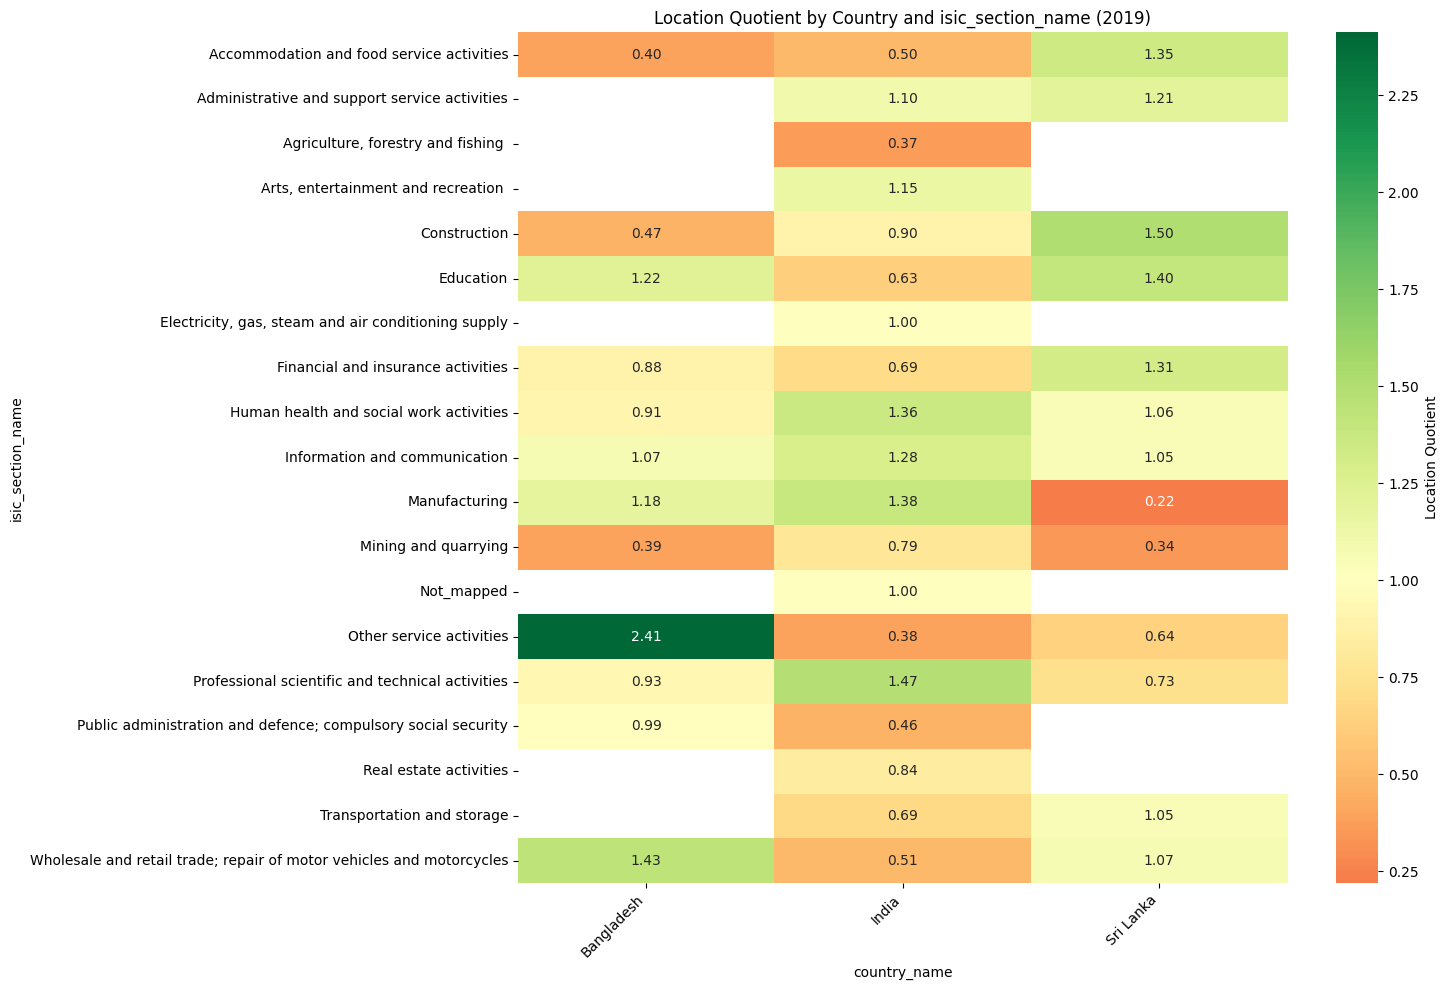

In [529]:
plot_lq_heatmap(lq_section[lq_section['country_name'].isin(countries_of_interest)], year=2019)

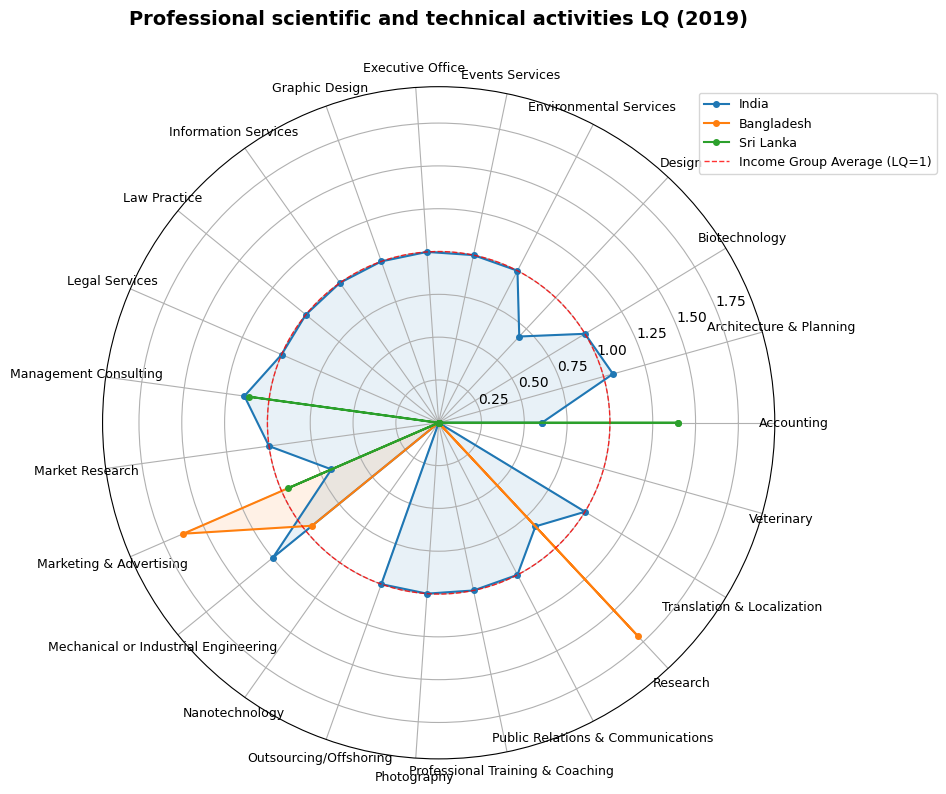

In [268]:
plot_multi_country_radar(lq_industry[lq_industry['isic_section_name']=='Professional scientific and technical activities'], countries_of_interest, year=2019, title = 'Professional scientific and technical activities LQ')

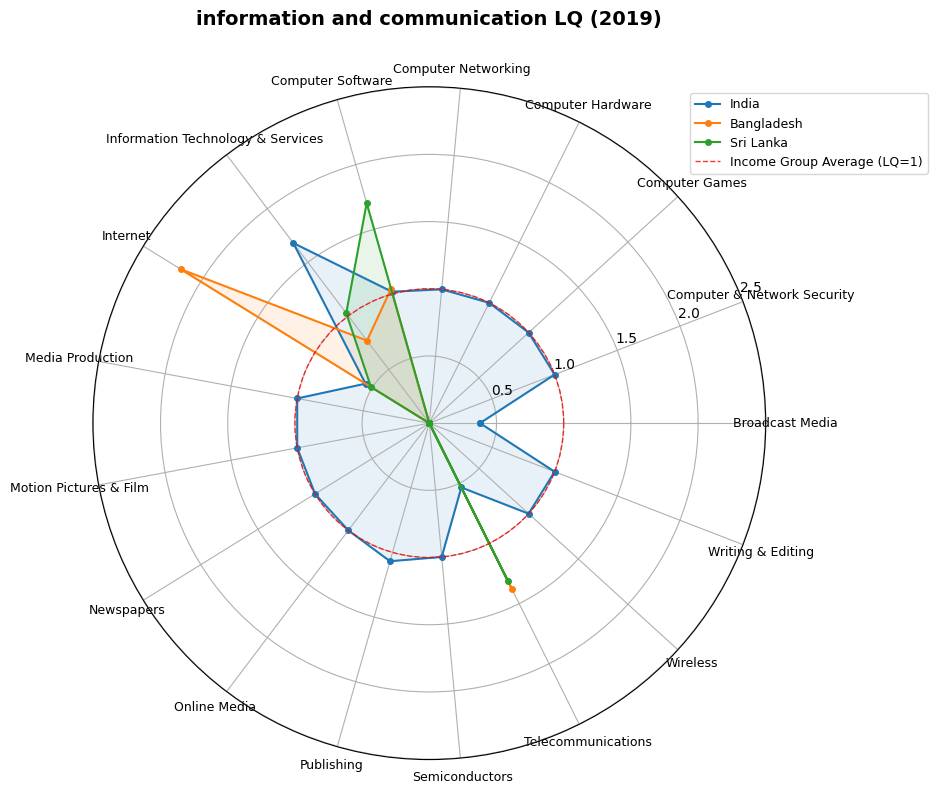

In [270]:
plot_multi_country_radar(lq_industry[lq_industry['isic_section_name']=='Information and communication'], countries_of_interest, year=2019, title='information and communication LQ')

## Country Migration

In [521]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import TabPanel, Tabs, Legend, LegendItem, HoverTool
from bokeh.palettes import Category10
import pandas as pd

def plot_bokeh_custom_tabs(df, tab_groups, x_col='year', y_col='column', group_col='c'):
    """
    Create a Bokeh plot with custom tabs, where you specify which 'c' values go in each tab
    
    Args:
        df: DataFrame with columns 'year', 'c', 'column'
        tab_groups: Dictionary where keys are tab names and values are lists of 'c' values
                   Example: {'Tab 1': ['c1', 'c2'], 'Tab 2': ['c3', 'c4', 'c5']}
        x_col: Column name for x-axis (default: 'year')
        y_col: Column name for y-axis (default: 'column')
        group_col: Column name for grouping (default: 'c')
    """
    # Enable notebook output
    output_notebook()
    
    # Create a list to store tab panels
    tab_panels = []
    
    # Create a plot for each tab group
    for tab_name, c_values in tab_groups.items():
        # Create a new plot for this tab
        p = figure(
            title=f"{tab_name}: {', '.join(map(str, c_values))}",
            x_axis_label=x_col.title(),
            y_axis_label=y_col.title(),
            width=700,
            height=500,
            tools="pan,wheel_zoom,box_zoom,reset,save",
            toolbar_location="above"
        )

        p.xaxis.ticker = list(range(int(df[x_col].min()), int(df[x_col].max()) + 1))
        
        # Add custom hover tool
        hover = HoverTool(tooltips=[
            (x_col.title(), "@x"),
            (y_col.title(), "@y"),
            ("Group", "@group")
        ])
        p.add_tools(hover)
        
        legend_items = []
        
        # Plot each 'c' value in this tab
        for i, c_value in enumerate(c_values):
            # Filter data for this 'c' value
            group_data = df[df[group_col] == c_value].sort_values(x_col)
            
            if group_data.empty:
                print(f"Warning: No data found for {group_col} = {c_value}")
                continue
                
            # Choose color
            color = Category10[10][i % 10]
            
            # Create ColumnDataSource for hover data
            source_data = {
                'x': group_data[x_col],
                'y': group_data[y_col],
                'group': [str(c_value)] * len(group_data)
            }
            
            # Add line and circle markers
            line = p.line('x', 'y', source=source_data,
                         line_width=3, color=color, alpha=0.8)
            scatter = p.scatter('x', 'y', source=source_data, size=8, color=color, alpha=0.8)


            
            # Add to legend
            legend_items.append(LegendItem(label=str(c_value), renderers=[line, scatter]))
        
        # Add legend if there are items
        if legend_items:
            legend = Legend(items=legend_items, location="top_right")
            p.add_layout(legend, 'right')
            p.legend.click_policy = "hide"  # Allow hiding lines by clicking legend
        
        # Customize the plot
        p.title.text_font_size = "16pt"
        p.title.text_font_style = "bold"
        p.xaxis.axis_label_text_font_size = "14pt"
        p.yaxis.axis_label_text_font_size = "14pt"
        p.grid.grid_line_alpha = 0.3
        
        # Create tab panel
        tab = TabPanel(child=p, title=tab_name)
        tab_panels.append(tab)
    
    # Create tabs widget
    tabs = Tabs(tabs=tab_panels, width=950)
    
    # Show the plot in notebook
    show(tabs)

country_flows['year'] = country_flows['year'].astype(str)
performance_tabs = {
    'South Asia': countries_of_interest,
    'Comparative Countries': benchmark_countries,
}
plot_bokeh_custom_tabs(country_flows, performance_tabs, x_col='year', y_col='inflow_outflow_ratio', group_col='country_region')

Loading BokehJS ...

In [371]:
cm_flow = country_migration[country_migration['base_country_name'].isin(countries_of_interest+benchmark_countries)][['base_country_name', 'target_country_name',
                                        'inflow_2015', 'outflow_2015', 'grossflow_2015', 'netflow_2015',
       'total_member_cnt_2015', 'net_per_10K_2015', 'inflow_2016',
       'outflow_2016', 'grossflow_2016', 'netflow_2016',
       'total_member_cnt_2016', 'net_per_10K_2016', 'inflow_2017',
       'outflow_2017', 'grossflow_2017', 'netflow_2017',
       'total_member_cnt_2017', 'net_per_10K_2017', 'inflow_2018',
       'outflow_2018', 'grossflow_2018', 'netflow_2018',
       'total_member_cnt_2018', 'net_per_10K_2018', 'inflow_2019',
       'outflow_2019', 'grossflow_2019', 'netflow_2019',
       'total_member_cnt_2019', 'net_per_10K_2019']].groupby('base_country_name')[['inflow_2015', 'outflow_2015', 
                                                                                   'inflow_2016', 'outflow_2016',
                                                                                   'inflow_2017', 'outflow_2017',
                                                                                   'inflow_2018', 'outflow_2018',
                                                                                   'inflow_2019', 'outflow_2019']].sum().reset_index()

In [440]:
def reshape_migration_data_melt(df, id_vars=['base_country_name']):
    """
    Reshape migration data using pandas melt function.
    """
    
    # Melt inflow columns
    inflow_cols = [col for col in df.columns if col.startswith('inflow_')]
    inflow_df = df.melt(
        id_vars=id_vars,
        value_vars=inflow_cols,
        var_name='year_type',
        value_name='inflow'
    )
    inflow_df['year'] = inflow_df['year_type'].str.extract('(\d+)').astype(int)
    inflow_df = inflow_df[id_vars + ['year', 'inflow']]  # Fixed: added id_vars
    
    # Melt outflow columns
    outflow_cols = [col for col in df.columns if col.startswith('outflow_')]
    outflow_df = df.melt(
        id_vars=id_vars,
        value_vars=outflow_cols,
        var_name='year_type',
        value_name='outflow'
    )
    outflow_df['year'] = outflow_df['year_type'].str.extract('(\d+)').astype(int)
    outflow_df = outflow_df[id_vars + ['year', 'outflow']]  # Fixed: consistent with inflow_df
    
    # Merge inflow and outflow data
    result = pd.merge(
        inflow_df, 
        outflow_df, 
        on=id_vars + ['year'],  # Fixed: removed extra space
        how='outer'
    )
    
    return result.sort_values(id_vars + ['year']).reset_index(drop=True)  # Fixed: removed extra space

In [372]:
cm_flow = reshape_migration_data_melt(cm_flow)

In [367]:
country_members = country_migration[['base_country_name', 'total_member_cnt_2015', 'total_member_cnt_2016','total_member_cnt_2017','total_member_cnt_2018','total_member_cnt_2019']].drop_duplicates()
member_cols = [col for col in country_members.columns if col.startswith('total_member_cnt_')]
country_members = country_members.melt(
        id_vars=['base_country_name'],
        value_vars=member_cols,
        var_name='year_type',
        value_name='total_members'
    )
country_members['year'] = country_members['year_type'].str.extract('(\d+)').astype(int)
country_members = country_members[['base_country_name', 'year', 'total_members']]

In [378]:
cm_flow['netflow'] = cm_flow['inflow'] - cm_flow['outflow']
cm_flow = cm_flow.merge(country_members, on=['base_country_name', 'year'], how='left')

In [ ]:
cm_flow['inflow_per_10K'] = cm_flow['inflow']/(cm_flow['total_members'] / 10000)
cm_flow['outflow_per_10K'] = cm_flow['outflow']/(cm_flow['total_members'] / 10000)
cm_flow['netflow_per_10K'] = cm_flow['netflow']/(cm_flow['total_members'] / 10000)

In [527]:
performance_tabs = {
    'South Asia': countries_of_interest,
    'Comparative Countries': benchmark_countries,
}
plot_bokeh_custom_tabs(cm_flow, performance_tabs, x_col='year', y_col='netflow_per_10K', group_col='base_country_name')

Loading BokehJS ...

In [520]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import TabPanel, Tabs, HoverTool, ColumnDataSource
from bokeh.palettes import Category10
import pandas as pd
import numpy as np

def plot_source_country_tabs(df, source_countries, metric_col='s2d_d2s_ratio', top_dest_n=5):
    """
    Create Bokeh tabs with stacked bar charts for specified source countries
    
    Args:
        df: DataFrame with columns 'year', 'source_country_region', 'dest_country_region', metric
        source_countries: List of source countries to create tabs for
        metric_col: Column to visualize (default: 's2d_d2s_ratio')
        top_dest_n: Number of top destination countries to include in stacks (default: 5)
    """
    output_notebook()
    
    tab_panels = []
    
    for source_country in source_countries:
        # Filter data for this source country
        source_data = df[df['source_country_region'] == source_country]
        
        if source_data.empty:
            print(f"Warning: No data found for source country: {source_country}")
            continue
        
        # Find top N destination countries for this source
        top_destinations = (source_data.groupby('dest_country_region')[metric_col]
                           .sum()  # or .mean() depending on your preference
                           .nlargest(top_dest_n)
                           .index.tolist())
        
        # Filter to top destinations
        filtered_data = source_data[source_data['dest_country_region'].isin(top_destinations)]
        
        if filtered_data.empty:
            continue
        
        # Get years for this source country
        years = sorted(filtered_data['year'].unique())
        
        # Prepare data for stacked bars
        plot_data = []
        for year in years:
            year_data = filtered_data[filtered_data['year'] == year]
            year_bottom = 0
            
            for dest in top_destinations:
                dest_value = year_data[year_data['dest_country_region'] == dest][metric_col].sum()
                plot_data.append({
                    'year': year,
                    'dest_country': dest,
                    'value': dest_value,
                    'bottom': year_bottom,
                    'top': year_bottom + dest_value
                })
                year_bottom += dest_value
        
        plot_df = pd.DataFrame(plot_data)
        
        # Create figure for this source country
        p = figure(
            title=f"Migration Ratios from {source_country} (Top {top_dest_n} Destinations)",
            x_axis_label="Year",
            y_axis_label=metric_col.replace('_', ' ').title(),
            width=700,
            height=500,
            tools="pan,wheel_zoom,box_zoom,reset,save",
            toolbar_location="above"
        )
        
        # Set x-axis to show only whole years
        p.xaxis.ticker = years
        
        # Colors for each destination country
        colors = Category10[max(10, len(top_destinations))][:len(top_destinations)]
        color_map = dict(zip(top_destinations, colors))
        
        # Add color column to dataframe
        plot_df['color'] = plot_df['dest_country'].map(color_map)
        
        # Create ColumnDataSource
        source_cds = ColumnDataSource(plot_df)
        
        # Create stacked bars
        bars = p.vbar(
            x='year',
            width=0.8,
            bottom='bottom',
            top='top',
            source=source_cds,
            color='color',
            alpha=0.8,
            legend_field='dest_country'
        )
        
        # Add hover tool
        hover = HoverTool(
            renderers=[bars],
            tooltips=[
                ("Year", "@year"),
                ("Destination", "@dest_country"),
                ("Value", "@value{0.000}"),
                ("Cumulative", "@bottom{0.000} - @top{0.000}")
            ]
        )
        p.add_tools(hover)
        
        # Customize legend and styling
        p.legend.location = "top_left"
        p.legend.click_policy = "hide"
        p.legend.title = "Destination Countries"
        
        p.title.text_font_size = "16pt"
        p.title.text_font_style = "bold"
        p.xaxis.axis_label_text_font_size = "14pt"
        p.yaxis.axis_label_text_font_size = "14pt"
        p.grid.grid_line_alpha = 0.3
        
        # Create tab panel
        tab = TabPanel(child=p, title=source_country)
        tab_panels.append(tab)
    
    # Create tabs widget
    if tab_panels:
        tabs = Tabs(tabs=tab_panels, width=950)
        show(tabs)
    else:
        print("No data found for any of the specified source countries")

# Usage example:
source_countries_list = countries_of_interest
plot_source_country_tabs(pairwise_country_migration, source_countries_list, metric_col='s2d_d2s_ratio', top_dest_n=5)

Loading BokehJS ...

In [456]:
pairwise_flows = country_migration[['base_country_name', 'target_country_name','inflow_2015', 'outflow_2015', 
                                    'inflow_2016', 'outflow_2016','inflow_2017', 'outflow_2017','inflow_2018', 'outflow_2018',
                                    'inflow_2019', 'outflow_2019']]
pairwise_flows = reshape_migration_data_melt(pairwise_flows, id_vars=['base_country_name', 'target_country_name'])
pairwise_flows['s2d_d2s_ratio'] = pairwise_flows['outflow'] / pairwise_flows['inflow']

pairwise_flows.rename(columns={'base_country_name': 'source_country_region', 
                                    'target_country_name': 'dest_country_region'}, inplace=True)

In [526]:
source_countries_list = countries_of_interest

plot_source_country_tabs(pairwise_flows, source_countries_list, metric_col='s2d_d2s_ratio', top_dest_n=5)

Loading BokehJS ...

## Industry Migration

In [525]:
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import ColumnDataSource, HoverTool, Tabs, TabPanel, Legend,  Toggle, LegendItem, CustomJS, Select, Button
from bokeh.palettes import Category20
from bokeh.layouts import column

def create_industry_performance_plots(df, country='India'):
    """Create interactive plots showing industry performance in Bangladesh, with toggle to filter from 2022."""
    output_notebook()

    # Filter data for Bangladesh
    bd_data = df[df['country_region'] == country].copy()

    # Convert Month to datetime
    bd_data['year'] = pd.to_datetime(bd_data['year'], format='%Y')

    # Calculate average inflow_outflow_rate for each industry
    industry_avg = bd_data.groupby('l1_industry_name')['inflow_outflow_ratio'].mean().sort_values(ascending=False)

    # Split industries into quartiles (5 industries each)
    top_5 = industry_avg.head(5).index.tolist()
    upper_mid_5 = industry_avg.iloc[5:10].index.tolist()
    lower_mid_5 = industry_avg.iloc[10:15].index.tolist()
    bottom_5 = industry_avg.iloc[15:].index.tolist()

    # Define quartile categories
    categories = [
        ('High Inflow', top_5, 'High Inflow Industries(1st Quartile)'),
        ('Medium Inflow', upper_mid_5, 'Medium Inflow Industries (2nd Quartile)'),
        ('Medium Outflow', lower_mid_5, 'Medium Outflow Industries (3rd Quartile)'),
        ('High Outflow', bottom_5, 'High Outflow Industries (4th Quartile)')
    ]

    tabs = []

    # Create one tab per industry category
    for tab_title, industries, plot_title in categories:
        # Prepare full and filtered data
        plot_data_full = bd_data[bd_data['l1_industry_name'].isin(industries)].copy()
        #plot_data_filtered = plot_data_full[plot_data_full['Month'] >= '2022-01-01'].copy()

        # Create figure
        p = figure(
            title=f"LinkedIn Industry Migration: {plot_title} in {country}",
            x_axis_type='datetime',
            width=700,
            height=500,
            background_fill_color="#f8f9fa"
        )

        legend_items = []
        js_sources = []

        for i, industry in enumerate(industries):
            color = Category20[10][i]

            full_industry_data = plot_data_full[plot_data_full['l1_industry_name'] == industry]
            #filtered_industry_data = plot_data_filtered[plot_data_filtered['Industry'] == industry]

            source = ColumnDataSource(full_industry_data)
            source_full = ColumnDataSource(full_industry_data)
            #source_filtered = ColumnDataSource(filtered_industry_data)

            line = p.line(
                x='year',
                y='inflow_outflow_ratio',
                source=source,
                line_width=3,
                color=color
            )

            legend_items.append((f"{industry} (Avg: {industry_avg[industry]:.2f}%)", [line]))
            js_sources.append({'source': source, 'full': source_full, 'filtered': source_full})

        # Add hover
        p.add_tools(HoverTool(
            tooltips=[
                ("Year", "@Year{%Y}"),
                ("Inflow Outflow Ratio", "@{inflow_outflow_ratio}{0.00}"),
                ("Industry", "@l1_industry_name")
            ],
            formatters={"@Month": "datetime"},
            mode='vline'
        ))

        # Axes labels and styling
        p.xaxis.axis_label = 'Year'
        p.yaxis.axis_label = 'Inflow Outflow Ratio'
        p.xaxis.axis_label_text_font_size = '12pt'
        p.yaxis.axis_label_text_font_size = '12pt'
        p.xaxis.major_label_text_font_size = '10pt'
        p.yaxis.major_label_text_font_size = '10pt'
        p.title.text_font_size = '14pt'
        p.grid.grid_line_color = "gray"
        p.grid.grid_line_alpha = 0.3

        # Add legend
        legend = Legend(
            items=legend_items,
            orientation='horizontal',
            spacing=20,
            padding=10,
            click_policy="hide",
            label_text_font_size='9pt',
            border_line_color="gray",
            border_line_alpha=0.5,
            background_fill_alpha=0.7,
            nrows=3
        )
        p.add_layout(legend, 'below')

        # # Toggle button
        # toggle = Toggle(label="Filter from 2022", button_type="success", active=False)

        # JS callback
    #     callback_code = """
    #         for (let i = 0; i < sources.length; i++) {
    #             sources[i].data = toggle.active ? filtered[i].data : full[i].data;
    #             sources[i].change.emit();
    #         }
    #         toggle.label = toggle.active ? 'Show full range' : 'Filter from 2022';
    #         toggle.button_type = toggle.active ? 'warning' : 'success';
    # """

        # callback = CustomJS(args={
        #     "toggle": toggle,
        #     "sources": [src['source'] for src in js_sources],
        #     "full": [src['full'] for src in js_sources],
        #     #"filtered": [src['filtered'] for src in js_sources]
        #     }, code=callback_code)

        # toggle.js_on_change("active", callback)

        # Combine toggle and plot
        tab_layout = column(p)
        tab = TabPanel(child=tab_layout, title=tab_title)
        tabs.append(tab)

    # Show tabs
    if tabs:
        tabs_layout = Tabs(tabs=tabs)
        show(tabs_layout)
    else:
        print("No data available for visualization.")


create_industry_performance_plots(country_industry_flow, country='India')


Loading BokehJS ...

In [519]:
def plot_stacked_bars_by_category(df, source_countries, category_col, destination_col, 
                                 metric_col, top_category_n=10, top_dest_n=5, base_year=2022):
    """
    Create stacked bar charts for any category showing top destinations
    One tab per category, stacked bars by destination
    
    Args:
        df: DataFrame with migration data
        source_countries: List of source countries to analyze
        category_col: Column name to create tabs for (e.g., 'l1_industry_name', 'skill_level', etc.)
        destination_col: Column name for destinations (e.g., 'dest_country_region')
        metric_col: Column name for the metric to plot (e.g., 's2d_d2s_ratio', 'inflow_outflow_ratio')
        top_category_n: Number of top categories to analyze per country
        top_dest_n: Number of top destinations to show per category
        base_year: Year to use for ranking top categories and destinations
    """
    output_notebook()
    
    for country in source_countries:
        
        country_data = df[df['source_country_region'] == country]
        
        if country_data.empty:
            print(f"Warning: No data found for {country}")
            continue
        
        # Get top categories for this country based on base_year data
        base_year_data = country_data[country_data['year'] == base_year]
        top_categories = (base_year_data.groupby(category_col)[metric_col]
                         .sum()
                         .nlargest(top_category_n)
                         .index.tolist())
        
        # Create tabs for stacked bar charts
        tab_panels = []
        
        for category in top_categories:
            # Filter to this category only
            category_data = country_data[country_data[category_col] == category]
            
            # Find top destinations for this category in base year
            category_base_year = category_data[category_data['year'] == base_year]
            top_destinations = (category_base_year.groupby(destination_col)[metric_col]
                               .sum()
                               .nlargest(top_dest_n)
                               .index.tolist())
            
            # Filter to top destinations only
            filtered_category_data = category_data[
                category_data[destination_col].isin(top_destinations)
            ]
            
            if filtered_category_data.empty:
                continue
            
            # Get years for this category
            years = sorted(filtered_category_data['year'].unique())
            
            # Prepare data for stacked bars
            plot_data = []
            for year in years:
                year_data = filtered_category_data[filtered_category_data['year'] == year]
                year_bottom = 0
                
                for dest in top_destinations:
                    dest_value = year_data[year_data[destination_col] == dest][metric_col].sum()
                    plot_data.append({
                        'year': year,
                        'destination': dest,
                        'value': dest_value,
                        'bottom': year_bottom,
                        'top': year_bottom + dest_value
                    })
                    year_bottom += dest_value
            
            plot_df = pd.DataFrame(plot_data)
            
            # Create figure for this category
            p = figure(
                title=f"{country}: {category}",
                x_axis_label="Year",
                y_axis_label=metric_col.replace('_', ' ').title(),
                width=700,
                height=500,
                tools="pan,wheel_zoom,box_zoom,reset,save",
                toolbar_location="above"
            )
            
            # Set x-axis to show only whole years
            p.xaxis.ticker = years
            
            # Colors for each destination
            colors = Category10[max(10, len(top_destinations))][:len(top_destinations)]
            color_map = dict(zip(top_destinations, colors))
            
            # Add color column to dataframe
            plot_df['color'] = plot_df['destination'].map(color_map)
            
            # Create ColumnDataSource
            source_cds = ColumnDataSource(plot_df)
            
            # Create stacked bars
            bars = p.vbar(
                x='year',
                width=0.8,
                bottom='bottom',
                top='top',
                source=source_cds,
                color='color',
                alpha=0.8,
                legend_field='destination'
            )
            
            # Add hover tool
            hover = HoverTool(
                renderers=[bars],
                tooltips=[
                    ("Year", "@year"),
                    ("Destination", "@destination"),
                    ("Value", "@value{0.000}"),
                    ("Cumulative", "@bottom{0.000} - @top{0.000}")
                ]
            )
            p.add_tools(hover)
            
            # Customize legend and styling
            p.legend.location = "top_left"
            p.legend.click_policy = "hide"
            p.legend.title = destination_col.replace('_', ' ').title()
            
            p.title.text_font_size = "16pt"
            p.title.text_font_style = "bold"
            p.xaxis.axis_label_text_font_size = "14pt"
            p.yaxis.axis_label_text_font_size = "14pt"
            p.grid.grid_line_alpha = 0.3
            
            # Create tab panel
            tab = TabPanel(child=p, title=str(category))
            tab_panels.append(tab)
        
        # Create tabs widget
        if tab_panels:
            tabs = Tabs(tabs=tab_panels, width=950)
            show(tabs)
        else:
            print(f"No data to display for {country}")

# Usage examples:

# Original industry usage
plot_stacked_bars_by_category(
    pairwise_industry_migration, 
    countries_of_interest[:1],
    category_col='l1_industry_name',
    destination_col='dest_country_region',
    metric_col='s2d_d2s_ratio',
    top_category_n=13, 
    top_dest_n=5
)

Loading BokehJS ...

## Skill Migration

In [522]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import TabPanel, Tabs, HoverTool, ColumnDataSource
from bokeh.palettes import Category10
import pandas as pd

def plot_skill_level_by_country_tabs(df, country_regions=None, x_col='year', y_col='inflow_outflow_ratio'):
    """
    Create Bokeh tabs with one tab per country region, showing lines for each skill level
    
    Args:
        df: DataFrame with columns ['year', 'country_region', 'skill_level', 'inflow_outflow_ratio', 'yoy_change']
        country_regions: List of country regions to include (if None, uses all)
        x_col: Column for x-axis (default: 'year')
        y_col: Column for y-axis (default: 'inflow_outflow_ratio')
    """
    output_notebook()
    
    # Get country regions to plot
    if country_regions is None:
        country_regions = sorted(df['country_region'].unique())
    
    # Get all skill levels for consistent coloring
    skill_levels = sorted(df['skill_level'].unique())
    colors = Category10[max(10, len(skill_levels))][:len(skill_levels)]
    color_map = dict(zip(skill_levels, colors))
    
    tab_panels = []
    
    for country in country_regions:
        # Filter data for this country
        country_data = df[df['country_region'] == country]
        
        if country_data.empty:
            print(f"Warning: No data found for {country}")
            continue
        
        # Get years for this country
        years = sorted(country_data[x_col].unique())
        
        # Create figure for this country
        p = figure(
            title=f"{country}",
            x_axis_label=x_col.replace('_', ' ').title(),
            y_axis_label=y_col.replace('_', ' ').title(),
            width=700,
            height=500,
            tools="pan,wheel_zoom,box_zoom,reset,save",
            toolbar_location="above"
        )
        
        # Set x-axis to show only whole years
        p.xaxis.ticker = years
        
        # Plot each skill level as a separate line
        for skill_level in skill_levels:
            skill_data = country_data[country_data['skill_level'] == skill_level]
            
            if skill_data.empty:
                continue
            
            # Sort by year for proper line connection
            skill_data = skill_data.sort_values(x_col)
            
            # Create ColumnDataSource for hover
            source_data = ColumnDataSource({
                'x': skill_data[x_col],
                'y': skill_data[y_col],
                'skill_level': [skill_level] * len(skill_data),
                'yoy_change': skill_data['yoy_change'] if 'yoy_change' in skill_data.columns else [0] * len(skill_data)
            })
            
            # Add line and scatter points
            line = p.line('x', 'y', source=source_data,
                         line_width=3, color=color_map[skill_level], alpha=0.8,
                         legend_label=skill_level)
            scatter = p.scatter('x', 'y', source=source_data,
                               size=8, color=color_map[skill_level], alpha=0.8)
        
        # Add hover tool
        hover = HoverTool(tooltips=[
            (x_col.replace('_', ' ').title(), "@x"),
            (y_col.replace('_', ' ').title(), "@y{0.000}"),
            ("Skill Level", "@skill_level"),
            ("YoY Change", "@yoy_change{0.000}")
        ])
        p.add_tools(hover)
        
        # Customize legend and styling
        p.legend.location = "top_right"
        p.legend.click_policy = "hide"
        p.legend.title = "Skill Level"
        
        p.title.text_font_size = "16pt"
        p.title.text_font_style = "bold"
        p.xaxis.axis_label_text_font_size = "14pt"
        p.yaxis.axis_label_text_font_size = "14pt"
        p.grid.grid_line_alpha = 0.3
        
        # Create tab panel
        tab = TabPanel(child=p, title=country)
        tab_panels.append(tab)
    
    # Create tabs widget
    if tab_panels:
        tabs = Tabs(tabs=tab_panels, width=950)
        show(tabs)
    else:
        print("No data found for any country regions")

def plot_skill_trends_analysis(df, country_regions=None, metric='inflow_outflow_ratio'):
    """
    Enhanced version with both inflow_outflow_ratio and yoy_change analysis
    """
    output_notebook()
    
    if country_regions is None:
        country_regions = sorted(df['country_region'].unique())
    
    for country in country_regions:
        print(f"\n=== {country} Skill Level Analysis ===")
        
        country_data = df[df['country_region'] == country]
        
        if country_data.empty:
            continue
        
        # Summary stats
        skill_summary = country_data.groupby('skill_level')[metric].agg(['mean', 'std', 'count']).round(3)
        print(f"Summary statistics for {metric}:")
        print(skill_summary)
        
        # Plot the main metric
        plot_skill_level_by_country_tabs(
            country_data,
            country_regions=[country],
            y_col=metric
        )



plot_skill_level_by_country_tabs(country_skill_flow, country_regions=countries_of_interest)


Loading BokehJS ...

In [524]:
# Skill level usage
plot_stacked_bars_by_category(
    pairwise_skill_migration, 
    countries_of_interest[:1],
    category_col='skill_level',
    destination_col='dest_country_region',
    metric_col='s2d_d2s_ratio',
    top_category_n=5, 
    top_dest_n=5
)


Loading BokehJS ...

In [523]:
# Skill level usage
plot_stacked_bars_by_category(
    pairwise_skill_migration, 
    countries_of_interest[1:2],
    category_col='skill_level',
    destination_col='dest_country_region',
    metric_col='s2d_d2s_ratio',
    top_category_n=5, 
    top_dest_n=5
)


Loading BokehJS ...

## References

Zhu, T. J., Orlowski, J., & Fritzler, A. (2018). World Bank Group-LinkedIn data insights: Jobs, skills and migration trends methodology and validation results. World Bank Group. https://documents1.worldbank.org/curated/en/827991542143093021/pdf/World-Bank-Group-LinkedIn-Data-Insights-Jobs-Skills-and-Migration-Trends-Methodology-and-Validation-Results.pdf